In [1]:
import qiskit
import numpy as np
from qiskit import *
from math import pi
from os import urandom

In [27]:
class CHSH_game:
    def __init__(self, rounds, eavesdrop=0, key_noise=0, meas_noise=0, ch_noise=0, modified=False, gamma=1, eta=0): # eavesdrop = (0: none); (1: triplet entanglement); (2: intercept-resend)
        self.rounds = rounds
        self.eavesdrop = eavesdrop
        self.choices = [None, None]
        self.key_noise = key_noise
        self.meas_noise = meas_noise
        self.ch_noise = ch_noise
        self.modified = modified
        self.gamma = gamma
        self.eta = eta
        self.basis = [[0, pi/4, pi/2], [0, pi/4, -pi/4], [0, 0, 0]]
        self.game = [None]
        self.output = [[], []]
        self.key = [[], []]
        self.raw_key = [[], []]
        self.s_val = 0
        if eavesdrop == 1: # three qubits entanglement
            self.choices.append(None)
            self.output.append([])
            self.key.append([])
        elif eavesdrop == 2: # intercept-resend
            self.choices.append(None)
            self.basis[2] = [0, pi/4]
            self.output.extend([[], []])
            self.key.extend([[], []])
    
    def key_noise_process(self):
        for u in [0,1]:
            for i in range(len(self.raw_key[u])):
                flip = np.random.choice(2, 1, p = [1-self.key_noise, self.key_noise])
                if flip == 0:
                    self.key[u].append(self.raw_key[u][i])
                elif flip == 1:
                    if self.raw_key[u][i] == 0:
                        self.key[u].append(1)
                    elif self.raw_key[u][i] == 1:
                        self.key[u].append(0)
                
        
    def create_round(self):
        alice = QuantumRegister(1, 'alice')
        bob = QuantumRegister(1, 'bob')
        m_a = ClassicalRegister(1, 'm_a')
        m_b = ClassicalRegister(1, 'm_b')
        if self.eavesdrop == 0:
            qc = QuantumCircuit(alice, bob, m_a, m_b)
        elif self.eavesdrop == 1:
            eve = QuantumRegister(1, 'eve')
            m_e = ClassicalRegister(1, 'm_e')
            qc = QuantumCircuit(alice, bob, eve, m_a, m_b)
        return qc
    
    def create_epr(self, qc):
        epr = QuantumCircuit(2)
        epr.h(0)
        epr.cx(0, 1)
        
        ##add channel noise
        break_ent = np.random.choice(2, 1, p = [1-self.ch_noise, self.ch_noise])
        if break_ent == 1:
            epr.h(0)
        
        qc.compose(epr, qubits=[0, 1], inplace=True)
        
        
    def create_eavesdropper(self, qc):
        entanglement = QuantumCircuit(2)
        entanglement.cx(0, 1)
        qc.compose(entanglement, qubits=[1, 2], inplace=True)
    
    def gen_random_choice(self, length, options=3):
#         from os import urandom
        choice = [int.from_bytes(urandom(1), 'big') % options for _ in range(length)]
        if options == 2:
            choice = [c+1 for c in choice]
        return choice
    
    def gen_test_rounds(self):
        return np.random.choice([0, 1], self.rounds, [1-self.gamma, self.gamma])
    
    def measure(self, player): # player = 0 / 1: Alice / Bob
        if player == 0:
            choice = self.gen_random_choice(self.rounds)
        elif player == 1:
            if self.modified:
                choice = self.gen_random_choice(self.rounds, options=2)
            else:
                choice = self.gen_random_choice(self.rounds)
        else:
            if self.eavesdrop == 1:
                choice = [0] * self.rounds # Eve should choose a strategy
        self.choices[player] = choice
        for i, c in enumerate(choice):
            basis = self.basis[player][c]
            self.game[i].ry(basis, player)
            self.game[i].measure(player, player)
            
    def retrieve_output(self):
        qasm_simulator = Aer.get_backend('qasm_simulator')
        for qc in self.game:
            result = execute(qc, qasm_simulator, shots=1, memory=True).result()
#             print('raw memory:', result.get_memory())
            memory = result.get_memory()[0].split()
            measured_bit_0 = int(memory[0])
            measured_bit_1 = int(memory[1])
            
            ##add measurement noise
            flipm = np.random.choice(2, 2, p = [1-self.meas_noise, self.meas_noise])
            if flipm[0] == 1:
                if measured_bit_0 == 0:
                    measured_bit_0 = 1
                else:
                    measured_bit_0 = 0
            if flipm[1] == 1:
                if measured_bit_1 == 0:
                    measured_bit_1 = 1
                else:
                    measured_bit_1 = 0
#             print('memory:', memory)
            self.output[0].append(measured_bit_0)
            self.output[1].append(measured_bit_1)
            if self.eavesdrop == 1:
                measured_bit_2 = int(memory[2])
                self.output[2].append(measured_bit_2)
            
    def evaluate(self):
        # TODO: CHSH inequality
        test = [[], [], [], []] #01+02+21-22
        test_rounds = self.gen_test_rounds()
        key_rounds = []
        for i in range(self.rounds):
            if self.choices[0][i] == self.choices[1][i] and self.choices[0][i] != 2:
                key_rounds.append(i)
                self.raw_key[0].append(self.output[0][i])
                self.raw_key[1].append(self.output[1][i])
                if self.eavesdrop == 1:
                    self.key[2].append(self.output[2][i])
                elif self.eavesdrop == 2:
                    self.key[2].append(self.output[2][i])
                    self.key[3].append(self.output[3][i])
                continue
            if test_rounds[i]: # is a test round
                ans = (-1) ** (self.output[0][i] + self.output[1][i])
                if self.choices[0][i] == 0 and self.choices[1][i] == 1:
                    test[0].append(ans)
                elif self.choices[0][i] == 0 and self.choices[1][i] == 2:
                    test[1].append(ans)
                elif self.choices[0][i] == 2 and self.choices[1][i] == 1:
                    test[2].append(ans)
                elif self.choices[0][i] == 2 and self.choices[1][i] == 2:
                    test[3].append(ans)
                
        self.key_noise_process()
        
        avg = [0, 0, 0, 0]
        for i in range(4):
            item = test[i]
            if len(item) > 0:
                avg[i] = sum(item)/len(item)
        self.s_val = abs(sum(avg) - 2*avg[3])
#         print(avg)

        # Modified -- Key extraction
        print(test_rounds)
        matches = 0
        key_test_rounds = 0
        self.final_key = []
        if self.modified:
            for i, r in enumerate(key_rounds):
                if test_rounds[r]: # is a test round && key round
                    key_test_rounds += 1
                    if self.key[0][i] == self.key[1][i]:
                        matches += 1
                else:
                    self.final_key.append(self.key[0][i])

            if key_test_rounds != 0:
                resemblance = matches / key_test_rounds
                if resemblance < 1 - self.eta:
                    print("Fail key resemblance test! Key resemblance = %f" % resemblance)
                else:
                    print("Pass key resemblance test! Key resemblance = %f" % resemblance)
            else:
                print("No key resemblance test.")
        else:
            self.final_key = self.key[0]
        
        # CHSH test
        if self.s_val > 2:
            print ("Pass CHSH test! s value = %f" % self.s_val)
            diff = sum(list(a^b for a,b in zip(game.key[0],game.key[1])))
#             print("Key length = %d" %len(game.key[0]))
            print("Key length = %d" %len(game.final_key))
            if diff > 0:
                print(" Key mismatach! diff: %d/%d" %(diff, len(game.key[0])))
        else:
            print ("Fail CHSH test! s value = %f" % self.s_val)
            diff_ab = sum(list(a^b for a,b in zip(game.key[0],game.key[1])))
            print("Key length = %d" %len(game.final_key))
            if self.eavesdrop == 1:
                diff_ae = sum(list(a^b for a,b in zip(game.key[0],game.key[2])))
                diff_be = sum(list(a^b for a,b in zip(game.key[1],game.key[2])))
                print("Key mismatch: %d (a, b), %d (a, e), %d (b, e)" % (diff_ab, diff_ae, diff_be))
#             if self.eavesdrop == 2:
            elif self.eavesdrop == 2:
                diff_ae = sum(list(a^b for a,b in zip(game.key[0],game.key[2])))
                diff_be = sum(list(a^b for a,b in zip(game.key[1],game.key[3])))
                print("Key mismatch: %d (a, b), %d (a, e), %d (b, e)" % (diff_ab, diff_ae, diff_be))
    
    def init(self):
        self.game = [self.create_round() for _ in range(self.rounds)]
        for qc in self.game:
            self.create_epr(qc)
            if self.eavesdrop == 1:
                self.create_eavesdropper(qc)
            qc.barrier()
            
    # ============================ for intercept-resend ==============================
    def create_init(self):
        ca = QuantumRegister(1, 'charlie_a')
        cb = QuantumRegister(1, 'charlie_b')
        m_ea = ClassicalRegister(1, 'm_ea')
        m_eb = ClassicalRegister(1, 'm_eb')
        qc = QuantumCircuit(ca, cb, m_ea, m_eb)
        self.create_epr(qc)
        qc.barrier()
        return qc

    def measure_eve(self):
        choice = [int.from_bytes(urandom(1), 'big') % 2 for _ in range(self.rounds)]
        self.choices[2] = choice
        for i, c in enumerate(choice):
            basis = self.basis[2][c]
            self.game[i].ry(basis, 0)
            self.game[i].ry(basis, 1)
            self.game[i].measure(0, 0)
            self.game[i].measure(1, 1)
            
    def store_eve(self):
        qasm_simulator = Aer.get_backend('qasm_simulator')
        for qc in self.game:
            result = execute(qc, qasm_simulator, shots=1, memory=True).result()
            memory = result.get_memory()[0].split()
            measured_bit_0 = int(memory[0])
            measured_bit_1 = int(memory[1])
            self.output[2].append(measured_bit_0)
            self.output[3].append(measured_bit_1)
    
    def create_fake(self):
        fa = QuantumRegister(1, 'fake_alice')
        fb = QuantumRegister(1, 'fake_bob')
        m_a = ClassicalRegister(1, 'm_a')
        m_b = ClassicalRegister(1, 'm_b')
        qc = QuantumCircuit(fa, fb, m_a, m_b)
        return qc
        
    def resend(self):
        self.game = [self.create_fake() for _ in range(self.rounds)]
        for i in range(self.rounds):
            if self.output[2][i]:
                self.game[i].x(0)
            if self.output[3][i]:
                self.game[i].x(1)
            self.game[i].barrier()
    
    def intercept_resend(self):
        self.game = [self.create_init() for _ in range(self.rounds)]
        self.measure_eve()
        self.store_eve()
        self.resend()
    # ================================================================================
    def start(self):
        if self.eavesdrop == 2:
            self.intercept_resend()
        else:
            self.init()
        self.measure(0) # Alice measure
        self.measure(1) # Bob measure
        if self.eavesdrop == 1: 
            self.measure(2) # Eve measure
        self.retrieve_output()
        self.evaluate()

In [24]:
rounds = 1000
game = CHSH_game(rounds, 0)
game.start()

Pass CHSH test! s value = 2.869782
Key length = 232


In [18]:
rounds = 1000
game = CHSH_game(rounds, 1)
game.start()

raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['0 1']
memory: ['0', '1']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['0 1']
memory: ['0', '1']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['0 1']
memory: ['0', '1']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['1 0']
memor

raw memory: ['0 1']
memory: ['0', '1']
raw memory: ['0 1']
memory: ['0', '1']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['1 0']
memory: ['1', '0']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['1 0']
memory: ['1', '0']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['0 1']
memory: ['0', '1']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['1 0']
memory: ['1', '0']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['0 0']
memor

raw memory: ['0 1']
memory: ['0', '1']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['0 1']
memory: ['0', '1']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['0 1']
memory: ['0', '1']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['0 1']
memory: ['0', '1']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['0 1']
memory: ['0', '1']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['1 1']
memor

raw memory: ['1 0']
memory: ['1', '0']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['0 1']
memory: ['0', '1']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['0 1']
memory: ['0', '1']
raw memory: ['1 0']
memory: ['1', '0']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['1 0']
memory: ['1', '0']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['0 1']
memory: ['0', '1']
raw memory: ['1 0']
memory: ['1', '0']
raw memory: ['0 1']
memor

raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['1 0']
memory: ['1', '0']
raw memory: ['1 0']
memory: ['1', '0']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['0 1']
memory: ['0', '1']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['1 0']
memory: ['1', '0']
raw memory: ['1 0']
memory: ['1', '0']
raw memory: ['1 0']
memory: ['1', '0']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['1 1']
memory: ['1', '1']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['0 0']
memory: ['0', '0']
raw memory: ['0 0']
memor

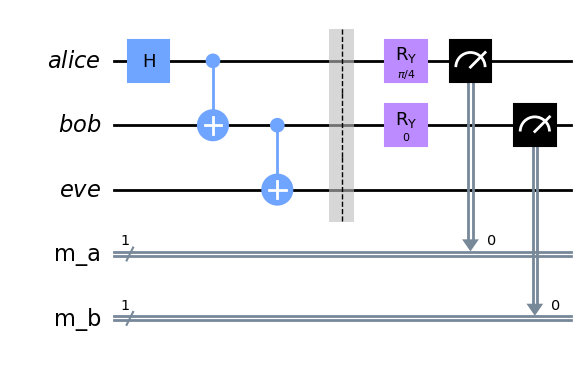

In [19]:
game.game[0].draw(output='mpl')

In [12]:
rounds = 1000
game = CHSH_game(rounds, 2)
game.start()

Fail CHSH test! s value = 1.204831
Key length = 209
Key mismatch: 29 (a, b), 14 (a, e), 19 (b, e)


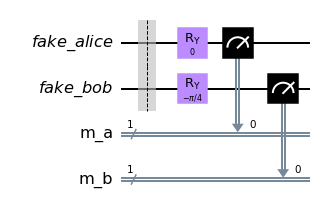

In [13]:
game.game[1].draw(output = 'mpl')

In [33]:
a = [1,2,3]
for i in range(len(a)):
    if a[i] == 2:
        a[i] = 10
print(a)
        

[1, 10, 3]


In [26]:
rounds = 100
game = CHSH_game(rounds, eavesdrop=0, key_noise=0.01, meas_noise=0, ch_noise=0, modified=False, gamma=0.05, eta=0.02)
game.start()

[1 1 1 0 1 0 0 1 1 0 0 1 1 0 0 0 1 1 1 0 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 1 1
 1 1 1 0 1 1 0 1 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0
 0 1 1 1 1 1 1 0 1 1 0 1 1 0 1 0 0 0 1 0 1 0 0 0 0 1]
Fail key resemblance test! Key resemblance = 0.928571
Pass CHSH test! s value = 2.333333
Key length = 11
 Key mismatach! diff: 1/25
